# Import libraries

In [316]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive
import scipy.spatial.distance as SSD
from skimage.filters import threshold_otsu, threshold_local

# Import data

## Bow-Fire directory

In [317]:
DATA_DIR = '/home/victor/Mestrado/Disciplinas/Visão Computacional/Projeto Final/bowfire/BowFire'
IMG_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'masks')

In [318]:
list_imgs = [os.path.join(IMG_DIR, x) for x in os.listdir(IMG_DIR)]
list_masks = [os.path.join(MASK_DIR, x) for x in os.listdir(MASK_DIR)]

list_imgs = sorted(list_imgs)
list_masks = sorted(list_masks)

print('Total de imagens', len(list_imgs))
print('Total de máscaras', len(list_masks))

Total de imagens 119
Total de máscaras 119


## Classic vision directory

In [319]:
DATA_DIR = 'classic_vision_imgs/'
list_classic_imgs = [os.path.join(DATA_DIR, x) for x in os.listdir(DATA_DIR)]
list_classic_imgs

['classic_vision_imgs/girl_nft.jpg']

# Image view

In [320]:
@interact(count = (0, len(list_classic_imgs)-1))
def show_classic_images(count):
    global img
    
    img = cv2.imread(list_classic_imgs[0], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('Off');

interactive(children=(IntSlider(value=0, description='count', max=0), Output()), _dom_classes=('widget-interac…

# Aplicando técnicas de visão clássica no dataset classic_vision

## Bilateral Filter

Iterating for radius = 10
Iterating for radius = 20
Iterating for radius = 30
Iterating for radius = 40
Iterating for radius = 50


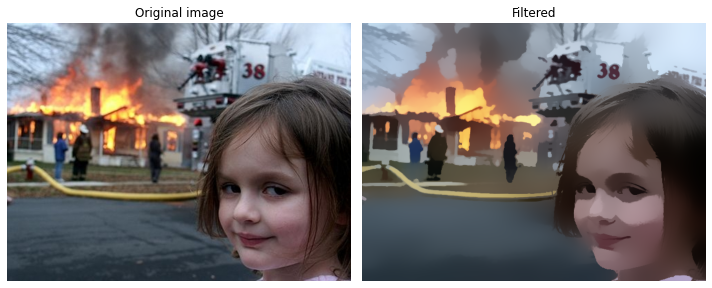

In [321]:
# Filtrar iterativamente com raio crescente
# blur = cv.bilateralFilter(<image>,<iterations>,<color radius>,<gradient radius>)
# 
global inputImg
inputImg = np.copy(img)
mult = 10
for x in range(1, 6):
    print('Iterating for radius =', x * mult)
    blur = cv2.bilateralFilter(inputImg,40,x * mult,x * mult)
    inputImg = np.copy(blur)
bilateralfilter(img, blur)

## Mahalanobis Distance

The formula to compute Mahalanobis distance is as follows:

$D^2 = (x-m)^{T} \cdot C^{-1} \cdot (x-m)$

**Where,**



$D^2$ is the square of the Mahalanobis distance. 

$x$          is the vector of the observation (row in a dataset), 

$m$          is the vector of mean values of independent variables (mean of each column), 

$C^{-1}$     is the inverse covariance matrix of independent variables. 

---

$(x – m)$ is essentially the distance of the vector from the mean. We then divide this by the covariance matrix (or multiply by the inverse of the covariance matrix).

If you think about it, this is essentially a multivariate equivalent of the regular standardization (z = (x – mu)/sigma). That is, z = (x vector) – (mean vector) / (covariance matrix).

In [322]:
# Equação: (u-mi)^T @ A^{-1} @ (u-mi)
# Passos para cálculo da matriz de covariância = A
''' 
Passo 01: média da variável.

    ||u - mi ||, dado que:
        * u = pixel da imagem
        * mi = média de cada uma das componentes - R,G,B. É um vetor
        
Passo 02: cálculo da variância de cada uma das componentes em relação a componente média.

    sigma_r, sigma_g, sigma_b
    Pega cada uma das componentes de entrada, menos mi em termos quadráticos
    
Passo 03: matriz de covariância o quanto componente varia ou individualmente ou conjuntamente

A = sigma_red_red    sigma_red_green    sigma_red_blue
    sigma_green_red  sigma_green_green  sigma_green_blue
    sigma_blue_red   sigma_blue_green   sigma_blue_blue

Passo 04: Cálculo da inversa da matriz de covariância, A^{-1}

'''
def mahalanobis(img):
    img_red   = img[:,:,0]
    img_green = img[:,:,1]
    img_blue  = img[:,:,2]

    mean_red   = np.mean(img[:,:,0])
    mean_green = np.mean(img[:,:,1])
    mean_blue  = np.mean(img[:,:,2])

    mi = np.array([mean_red, mean_green, mean_blue])
    
  
    # matriz de covariância
    covariance = np.cov([img_red.ravel(), img_green.ravel(), img_blue.ravel()])
    inv_cov = np.linalg.inv(covariance) # inv. covariance matrix
    
    height = img.shape[0]
    weigth = img.shape[1]
    
    result = np.zeros_like(img, dtype='float64')
    
    for h in range(height):
        for w in range(weigth):
            # array with particular pixels from each image
            u = np.array([img_red[h, w], img_green[h, w],img_blue[h, w]])
            
            # calculate mahalanobis distance and insert value as a pixel
            # scipy.spatial.distance.mahalanobis(u, mi, A^{-1})
            # sqrt(u-mi)A^{-1} * (u-mi).T
            result[h, w] = SSD.mahalanobis(u, mi, inv_cov)
    return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


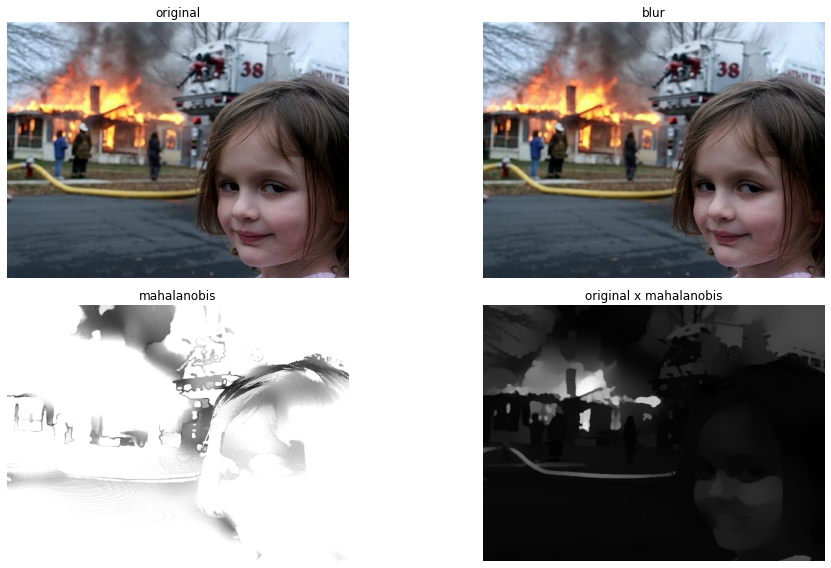

In [323]:
#@interact(count = (0, len(list_imgs)))
def show_mahalanobis(original_img, img):
    global gray
    global mahalanobis_img
    global multiplied_img
    
    # aplicando mahalanobis a imagem borrada
    mahalanobis_img = mahalanobis(img)
    
    # multiplicando a mask pela imagem original
    multiplied_img = img[:,:,0] * mahalanobis_img[:,:,0]
    
    fig, ax = plt.subplots(2,2, figsize=(15,8))
    ax[0,0].imshow(original_img, 'gray')
    ax[0,0].set_title('original')
    ax[0,0].axis('Off')
    
    ax[0,1].imshow(original_img)
    ax[0,1].set_title('blur')
    ax[0,1].axis('Off')
    
    ax[1,0].imshow(mahalanobis_img, 'gray')
    ax[1,0].set_title('mahalanobis')
    ax[1,0].axis('Off')
    
    ax[1,1].imshow(multiplied_img, 'gray')
    ax[1,1].set_title('original x mahalanobis')
    ax[1,1].axis('Off')
    
    plt.tight_layout()

#view_images(std_img)
show_mahalanobis(img, inputImg)

## Simple Threshold and Math Morphology

In [324]:
@interact(thresh=(0, 700, 1),
            kernel_opening=(0,50,2),
            kernel_closing=(0,60,2))

def simple_threshold(thresh,kernel_opening, kernel_closing):
    global closing
    global mask_with_morpho
    global dst
    global opening
    global closing
    
    image = multiplied_img.copy()
    # opening
    th, dst = cv2.threshold(image, thresh, 1000, cv2.THRESH_BINARY)

    #kernel_open = np.ones([kernel_opening, kernel_opening])
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_opening,kernel_opening))
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel_open)

    # closing
    #kernel_close = np.ones([kernel_closing, kernel_closing])
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_closing,kernel_closing))
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)

    mask_with_morpho = cv2.multiply(image, (closing))

    fig, ax = plt.subplots(2,2, figsize = (15,10))
    
    ax[0,0].imshow(img)
    ax[0,0].set_title('original')
    ax[0,0].axis('Off')
    
    ax[0,1].imshow(dst,'gray')
    ax[0,1].set_title('threshold img')
    ax[0,1].axis('Off')
    
    ax[1,0].imshow(opening, 'gray')
    ax[1,0].set_title('opening')
    ax[1,0].axis('Off')

    ax[1,1].imshow(closing, 'gray')
    ax[1,1].set_title('closing')
    ax[1,1].axis('Off')

# para a imagem 59
# threhs 360
# opening = 16
# closing = 10

# fire girl
# thrsh 631
# open 6
# closing 24

interactive(children=(IntSlider(value=350, description='thresh', max=700), IntSlider(value=24, description='ke…

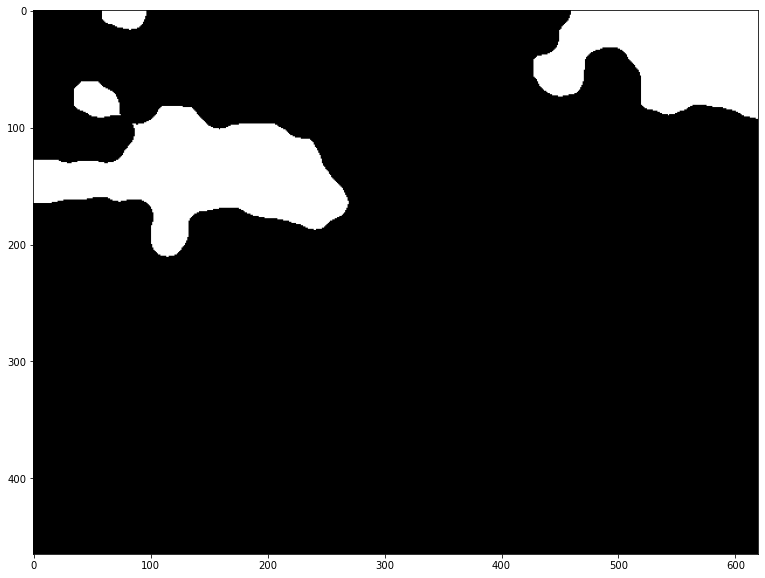

In [325]:
plt.figure(figsize=(15,10))
plt.imshow(closing,'gray');

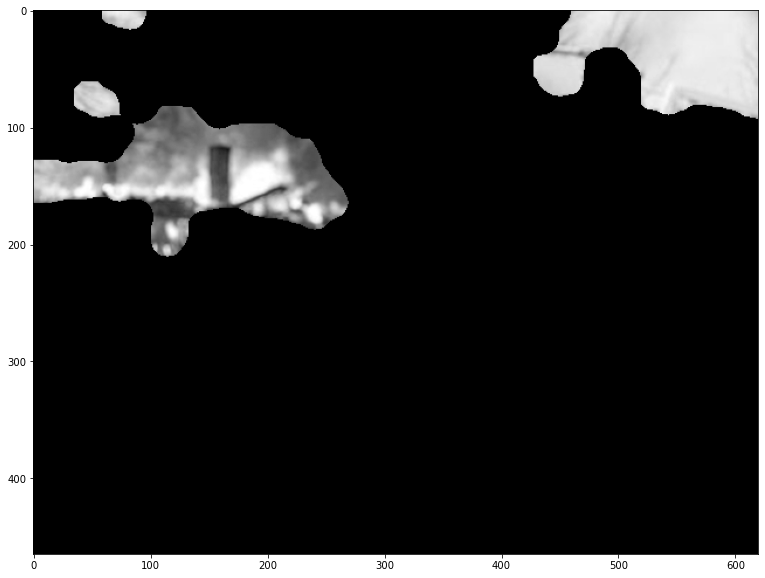

In [326]:
plt.figure(figsize=(15,10))
a = img[:,:,1] * closing
plt.imshow(a,'gray');

## Aplicando técnicas de visão clássica no dataset BowFire

In [ ]:
#IoU = Jaccard
#Dice = F1 Score

In [108]:
@interact(count = (0, len(list_imgs)-1))
def show_bowfire_images(count):
    global img
    global dataset_mask
    
    dataset_mask = cv2.imread(list_masks[count])
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    
    img = cv2.imread(list_imgs[count], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axs[0].imshow(img)
    axs[0].set_title('imagem')
    
    axs[1].imshow(dataset_mask)
    axs[1].set_title('mask')   
    
    for ax in axs:
        ax.axis('Off')
# imagem 96

interactive(children=(IntSlider(value=59, description='count', max=118), Output()), _dom_classes=('widget-inte…

## Bilateral Filter

Iterating for radius = 10
Iterating for radius = 20
Iterating for radius = 30
Iterating for radius = 40
Iterating for radius = 50


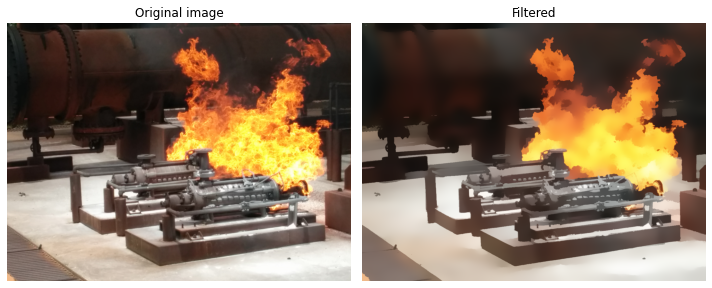

In [109]:
# Filtrar iterativamente com raio crescente
# blur = cv.bilateralFilter(<image>,<iterations>,<color radius>,<gradient radius>)
# 
global inputImg
inputImg = np.copy(img)
mult = 10
for x in range(1, 6):
    print('Iterating for radius =', x * mult)
    blur = cv2.bilateralFilter(inputImg,40,x * mult,x * mult)
    inputImg = np.copy(blur)
bilateralfilter(img, blur)

## Mahalanobis Distance

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


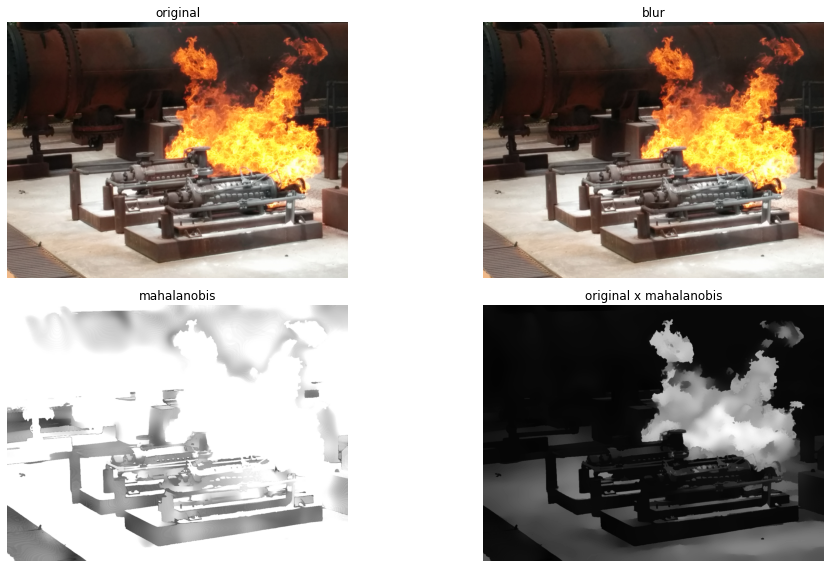

In [110]:
#@interact(count = (0, len(list_imgs)))
def show_mahalanobis(original_img, img):
    global gray
    global mahalanobis_img
    global multiplied_img
    
    # aplicando mahalanobis a imagem borrada
    mahalanobis_img = mahalanobis(img)
    
    # multiplicando a mask pela imagem original
    multiplied_img = img[:,:,0] * mahalanobis_img[:,:,0]
    
    fig, ax = plt.subplots(2,2, figsize=(15,8))
    ax[0,0].imshow(original_img, 'gray')
    ax[0,0].set_title('original')
    ax[0,0].axis('Off')
    
    ax[0,1].imshow(original_img)
    ax[0,1].set_title('blur')
    ax[0,1].axis('Off')
    
    ax[1,0].imshow(mahalanobis_img, 'gray')
    ax[1,0].set_title('mahalanobis')
    ax[1,0].axis('Off')
    
    ax[1,1].imshow(multiplied_img, 'gray')
    ax[1,1].set_title('original x mahalanobis')
    ax[1,1].axis('Off')
    
    plt.tight_layout()

#view_images(std_img)
show_mahalanobis(img, inputImg)

## Simple Threshold and Math Morphology

In [111]:
@interact(thresh=(0, 700, 1),
            kernel_opening=(0,50,2),
            kernel_closing=(0,60,2))

def simple_threshold(thresh,kernel_opening, kernel_closing):
    global closing
    global mask_with_morpho
    global dst
    global opening
    global closing
    
    image = multiplied_img.copy()
    # opening
    th, dst = cv2.threshold(image, thresh, 1000, cv2.THRESH_BINARY)

    #kernel_open = np.ones([kernel_opening, kernel_opening])
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_opening,kernel_opening))
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel_open)

    # closing
    #kernel_close = np.ones([kernel_closing, kernel_closing])
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_closing,kernel_closing))
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)

    mask_with_morpho = cv2.multiply(image, (closing))

    fig, ax = plt.subplots(2,2, figsize = (15,10))
    
    ax[0,0].imshow(img)
    ax[0,0].set_title('original')
    ax[0,0].axis('Off')
    
    ax[0,1].imshow(dst,'gray')
    ax[0,1].set_title('threshold img')
    ax[0,1].axis('Off')
    
    ax[1,0].imshow(opening, 'gray')
    ax[1,0].set_title('opening')
    ax[1,0].axis('Off')

    ax[1,1].imshow(closing, 'gray')
    ax[1,1].set_title('closing')
    ax[1,1].axis('Off')

# para a imagem 59
# threhs 360
# opening = 16
# closing = 10

# fire girl
# thrsh 631
# open 6
# closing 24

# fogo 97
# thrsh 630
# open 2
# closing 60

interactive(children=(IntSlider(value=350, description='thresh', max=700), IntSlider(value=24, description='ke…

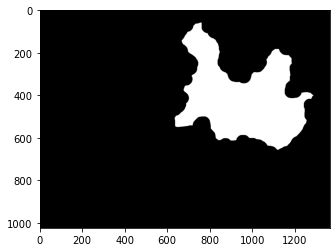

In [112]:
plt.figure(figsize=(8,4))
plt.imshow(closing,'gray');

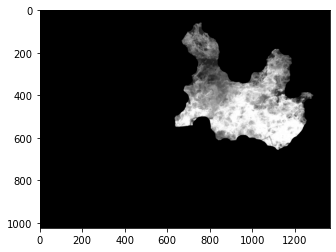

In [113]:
plt.figure(figsize=(8,4))
a = img[:,:,1] * closing
plt.imshow(a,'gray');

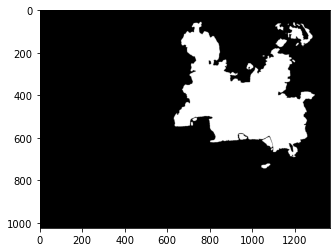

In [114]:
plt.figure(figsize=(8,4))
plt.imshow(dataset_mask,'gray');

## Jaccard (IoU) and F1 score (Dice)

In [312]:
from sklearn.metrics import jaccard_score, f1_score

In [313]:
mask = np.copy(dataset_mask)
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask.shape

(1024, 1365)

In [314]:
def data_eval(y_true, y_pred):
    jac = jaccard_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')
    
    print(f'Jaccard: {jac:.2}\nF1: {f1:.2f}') 

In [315]:
data_eval(mask, closing)

Jaccard: 0.87
F1: 0.93
